In [93]:
import scipy

In [180]:
import pandas as pd

cmip = pd.read_csv('data/cesm_data_variant.csv')
observed = pd.read_csv('data/cleaned_observed_ann_input.csv')

In [181]:
from hydra import initialize, compose

with initialize(version_base=None, config_path="./conf"):
    cfg = compose(config_name="config")
cmip_1985 = cmip[(cmip['year'] >= 1985) & (cmip['variant'] == 1)]
observed_1985 = observed[observed['year'] <= 2014]
cmip_var = cmip_1985[cfg.model.input + ['year','lat','lon']]
observed_var = observed_1985[cfg.model.input + ['year','lat','lon']]

In [137]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(cmip_var.loc[:,cfg.model.input])
cmip_var.loc[:,cfg.model.input] = scaler.transform(cmip_var.loc[:,cfg.model.input])
observed_var.loc[:,cfg.model.input] = scaler.transform(observed_var.loc[:,cfg.model.input])

/var/folders/1g/_wddvqdx1zn1sqjjw3s9m2940000gt/T/ipykernel_80768/2099167954.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmip_var.loc[:,cfg.model.input] = scaler.transform(cmip_var.loc[:,cfg.model.input])
/var/folders/1g/_wddvqdx1zn1sqjjw3s9m2940000gt/T/ipykernel_80768/2099167954.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observed_var.loc[:,cfg.model.input] = scaler.transform(observed_var.loc[:,cfg.model.input])


In [182]:
cmip_var.loc[:,'lat'] = cmip_var['lat'].round(6)
observed_var.loc[:,'lat'] = observed_var['lat'].round(6)
merged = pd.merge(cmip_var,observed_var,on=['lat','lon','year'],how='inner')

/var/folders/1g/_wddvqdx1zn1sqjjw3s9m2940000gt/T/ipykernel_80768/3241450366.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmip_var.loc[:,'lat'] = cmip_var['lat'].round(6)
/var/folders/1g/_wddvqdx1zn1sqjjw3s9m2940000gt/T/ipykernel_80768/3241450366.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observed_var.loc[:,'lat'] = observed_var['lat'].round(6)


In [152]:
scipy.stats.ks_2samp(merged['tas_JJA_x'],merged['tas_JJA_y'])

KstestResult(statistic=0.09662813102119461, pvalue=1.2475313424545629e-42)

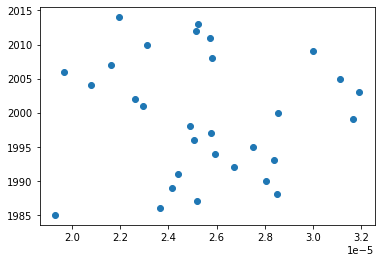

In [129]:
import matplotlib.pyplot as plt
plt.scatter(cell['year'],cell['pr_y'])
plt.scatter(cell['pr_x'],cell['year'])

In [183]:
import numpy as np
from sklearn.linear_model import LinearRegression

def linear_regression(X,y):
    # plt.scatter(cell['year'],cell['pr_x'])
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    xfit = np.linspace(1985, 2015, 30)
    yfit = model.predict(xfit[:, np.newaxis])

    # # Print the Intercept:
    # print('intercept:', model.intercept_)

    # # Print the Slope:
    # print('slope:', model.coef_) 

    # Plot the estimated linear regression line with matplotlib:
    # plt.scatter(X, y)
    # plt.plot(xfit, yfit);
    # plt.show()
    return yfit

In [184]:
# merged['detrended_cesm_tsl']  = merged['tsl_x'] - pred_for_cesm
# merged.loc[(merged['lat'] == lat) & (merged['lon'] == lon),'tsl_x'].reset_index()


for lat,lon in zip(merged['lat'],merged['lon']):
    cell = merged[(merged['lat'] == lat) & (merged['lon'] == lon)]
    X = cell['year'].values.reshape(-1,1)
    y = cell['tsl_x'].values.reshape(-1,1)
    y_1 = cell['tsl_y'].values.reshape(-1,1)
    pred_for_cesm = linear_regression(X,y)
    pred_for_observed = linear_regression(X,y_1)
    merged.loc[(merged['lat'] == lat) & (merged['lon'] == lon),'detrended_cesm_tsl'] = merged.loc[(merged['lat'] == lat) & (merged['lon'] == lon),'tsl_x'] - pred_for_cesm[:,0]
    merged.loc[(merged['lat'] == lat) & (merged['lon'] == lon),'detrended_observed_tsl'] = merged.loc[(merged['lat'] == lat) & (merged['lon'] == lon),'tsl_y'] - pred_for_observed[:,0]

In [187]:
scipy.stats.ks_2samp(merged['detrended_cesm_tsl'],merged['detrended_observed_tsl']),scipy.stats.ks_2samp(merged['tsl_x'],merged['tsl_y'])

(KstestResult(statistic=0.051059730250481716, pvalue=3.3666023302052367e-12),
 KstestResult(statistic=0.21416184971098268, pvalue=2.1227603297249714e-209))

In [192]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(merged.loc[:,['detrended_cesm_tsl','tas_DJF_x']])
merged.loc[:,['detrended_cesm_tsl','tas_DJF_x']] = scaler.transform(merged.loc[:,['detrended_cesm_tsl','tas_DJF_x']])
merged.loc[:,['detrended_observed_tsl','tas_DJF_y']] = scaler.transform(merged.loc[:,['detrended_observed_tsl','tas_DJF_y']])

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- detrended_observed_tsl
- tas_DJF_y
Feature names seen at fit time, yet now missing:
- detrended_cesm_tsl
- tas_DJF_x


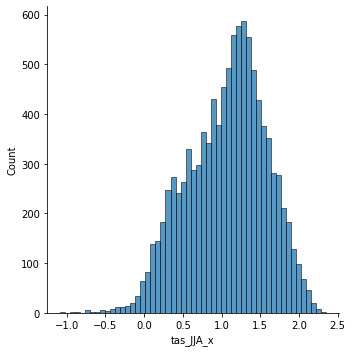

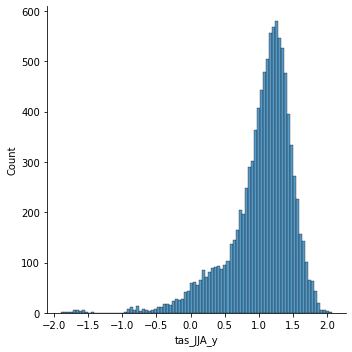

In [154]:
import seaborn as sns
sns.displot(merged, x="tas_JJA_x")
sns.displot(merged, x="tas_JJA_y")




In [144]:
merged['pr_y'].describe()

count    10380.000000
mean         0.622970
std          0.794172
min         -0.844235
25%          0.017247
50%          0.448189
75%          1.140773
max          6.088315
Name: pr_y, dtype: float64

In [145]:
merged['pr_x'].describe()

count    10380.000000
mean         0.498462
std          0.889305
min         -0.852823
25%         -0.164229
50%          0.274059
75%          0.956610
max          6.530365
Name: pr_x, dtype: float64